## Segmenting and Clustering Neighborhoods in the City of Toronto, Canada

Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.2-hecda079_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.2-py36_0 --> conda-forge::certifi-2020.4.5.2-py36h9f0ad1d_0
  openssl               anaconda::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


In [2]:
!conda install -c anaconda beautifulsoup4 --yes
!conda install -c anaconda lxml --yes
from bs4 import BeautifulSoup
print("done")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> anaconda::ca-certificates-2020.1.1-0
  certifi            conda-forge::certifi-2020.4.5.2-py36h~ --> anaconda::certifi-2020.4.5.2-py36_0
  openssl            conda-forge::openssl-1.1.1g-h516909a_0 --> anaconda::openssl-1.1.1g-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

done


### Cleaning Data to create a Dataframe 'df' for Toronto, Canada

In [3]:
#send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
page = BeautifulSoup(data,'html.parser')

# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []
 

In [4]:
# append the data into the respective lists
for row in page.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [5]:
# create a new DataFrame from the three lists
df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})
df.head()

PostalCode             Borough               Neighborhood
0      M1A\n      Not assigned\n               Not assigned
1      M2A\n      Not assigned\n               Not assigned
2      M3A\n        North York\n                  Parkwoods
3      M4A\n        North York\n           Victoria Village
4      M5A\n  Downtown Toronto\n  Regent Park, Harbourfront

In [6]:
df.shape

(180, 3)

In [7]:
# drop cells with value Not assigned
df_dropna = df[df.Borough != "Not assigned\n"].reset_index(drop=True)
df_dropna.head()

PostalCode             Borough                                 Neighborhood
0      M3A\n        North York\n                                    Parkwoods
1      M4A\n        North York\n                             Victoria Village
2      M5A\n  Downtown Toronto\n                    Regent Park, Harbourfront
3      M6A\n        North York\n             Lawrence Manor, Lawrence Heights
4      M7A\n  Downtown Toronto\n  Queen's Park, Ontario Provincial Government

In [8]:
df_dropna.shape

(103, 3)

## Answer 1

In [21]:
# group neighborhoods in the same borough
df_group = df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

In [23]:
# removing extra spaces to make both dataframes similar
df_group['Neighborhood'] = df_group['Neighborhood'].str.replace(' /', ',')
df_group['PostalCode'] = df_group['PostalCode'].str.replace('\n', '')
df_group['Borough'] = df_group['Borough'].str.replace('\n', '')
df_group.head()


PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [24]:
df_group.shape

(103, 3)

#### Using Csv file to get Coordinates

In [10]:
# getting longitude and latitudes
csv_path = 'https://cocl.us/Geospatial_data'
df_ll = pd.read_csv(csv_path)
df_ll.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [11]:
df_ll.shape

(103, 3)

In [12]:
df_ll.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
df_ll.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [14]:
df_group.head()

PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [16]:
df_group.shape

(103, 3)

In [17]:
df_ll.shape

(103, 3)

In [18]:
df_group.iloc[0,0] == df_ll.iloc[0,0]

True

### Answer 2

In [25]:
#merging dataframes
toronto_df = df_group.merge(df_ll, on="PostalCode", how='left')
toronto_df.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [26]:
toronto_df.shape

(103, 5)

In [27]:
toronto_df[toronto_df['Borough'].astype(str).str.contains('Toronto')]

PostalCode           Borough  \
37        M4E      East Toronto   
41        M4K      East Toronto   
42        M4L      East Toronto   
43        M4M      East Toronto   
44        M4N   Central Toronto   
45        M4P   Central Toronto   
46        M4R   Central Toronto   
47        M4S   Central Toronto   
48        M4T   Central Toronto   
49        M4V   Central Toronto   
50        M4W  Downtown Toronto   
51        M4X  Downtown Toronto   
52        M4Y  Downtown Toronto   
53        M5A  Downtown Toronto   
54        M5B  Downtown Toronto   
55        M5C  Downtown Toronto   
56        M5E  Downtown Toronto   
57        M5G  Downtown Toronto   
58        M5H  Downtown Toronto   
59        M5J  Downtown Toronto   
60        M5K  Downtown Toronto   
61        M5L  Downtown Toronto   
63        M5N   Central Toronto   
64        M5P   Central Toronto   
65        M5R   Central Toronto   
66        M5S  Downtown Toronto   
67        M5T  Downtown Toronto   
68        M5V  Downtown Toronto   
69        M5W  Downtown Toronto   
70        M5X  Downtown Toronto   
75        M6G  Downtown Toronto   
76        M6H      West Toronto   
77        M6J      West Toronto   
78        M6K      West Toronto   
82        M6P      West Toronto   
83        M6R      West Toronto   
84        M6S      West Toronto   
85        M7A  Downtown Toronto   
87        M7Y      East Toronto   

                                         Neighborhood   Latitude  Longitude  
37                                        The Beaches  43.676357 -79.293031  
41                       The Danforth West, Riverdale  43.679557 -79.352188  
42                     India Bazaar, The Beaches West  43.668999 -79.315572  
43                                    Studio District  43.659526 -79.340923  
44                                      Lawrence Park  43.728020 -79.388790  
45                                   Davisville North  43.712751 -79.390197  
46                 North Toronto West,  Lawrence Park  43.715383 -79.405678  
47                                         Davisville  43.704324 -79.388790  
48                        Moore Park, Summerhill East  43.689574 -79.383160  
49  Summerhill West, Rathnelly, South Hill, Forest...  43.686412 -79.400049  
50                                           Rosedale  43.679563 -79.377529  
51                        St. James Town, Cabbagetown  43.667967 -79.367675  
52                               Church and Wellesley  43.665860 -79.383160  
53                          Regent Park, Harbourfront  43.654260 -79.360636  
54                           Garden District, Ryerson  43.657162 -79.378937  
55                                     St. James Town  43.651494 -79.375418  
56                                        Berczy Park  43.644771 -79.373306  
57                                 Central Bay Street  43.657952 -79.387383  
58                           Richmond, Adelaide, King  43.650571 -79.384568  
59  Harbourfront East, Union Station, Toronto Islands  43.640816 -79.381752  
60           Toronto Dominion Centre, Design Exchange  43.647177 -79.381576  
61                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
63                                           Roselawn  43.711695 -79.416936  
64    Forest Hill North & West, Forest Hill Road Park  43.696948 -79.411307  
65                The Annex, North Midtown, Yorkville  43.672710 -79.405678  
66                     University of Toronto, Harbord  43.662696 -79.400049  
67          Kensington Market, Chinatown, Grange Park  43.653206 -79.400049  
68  CN Tower, King and Spadina, Railway Lands, Har...  43.628947 -79.394420  
69                                     Stn A PO Boxes  43.646435 -79.374846  
70             First Canadian Place, Underground city  43.648429 -79.382280  
75                                           Christie  43.669542 -79.422564  
76                       Dufferin, Dovercourt Village  43.669005 -79.442259  
77                          

Getting Toronto location using 'Geocode'

In [28]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Toronto Map using Folium

In [122]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

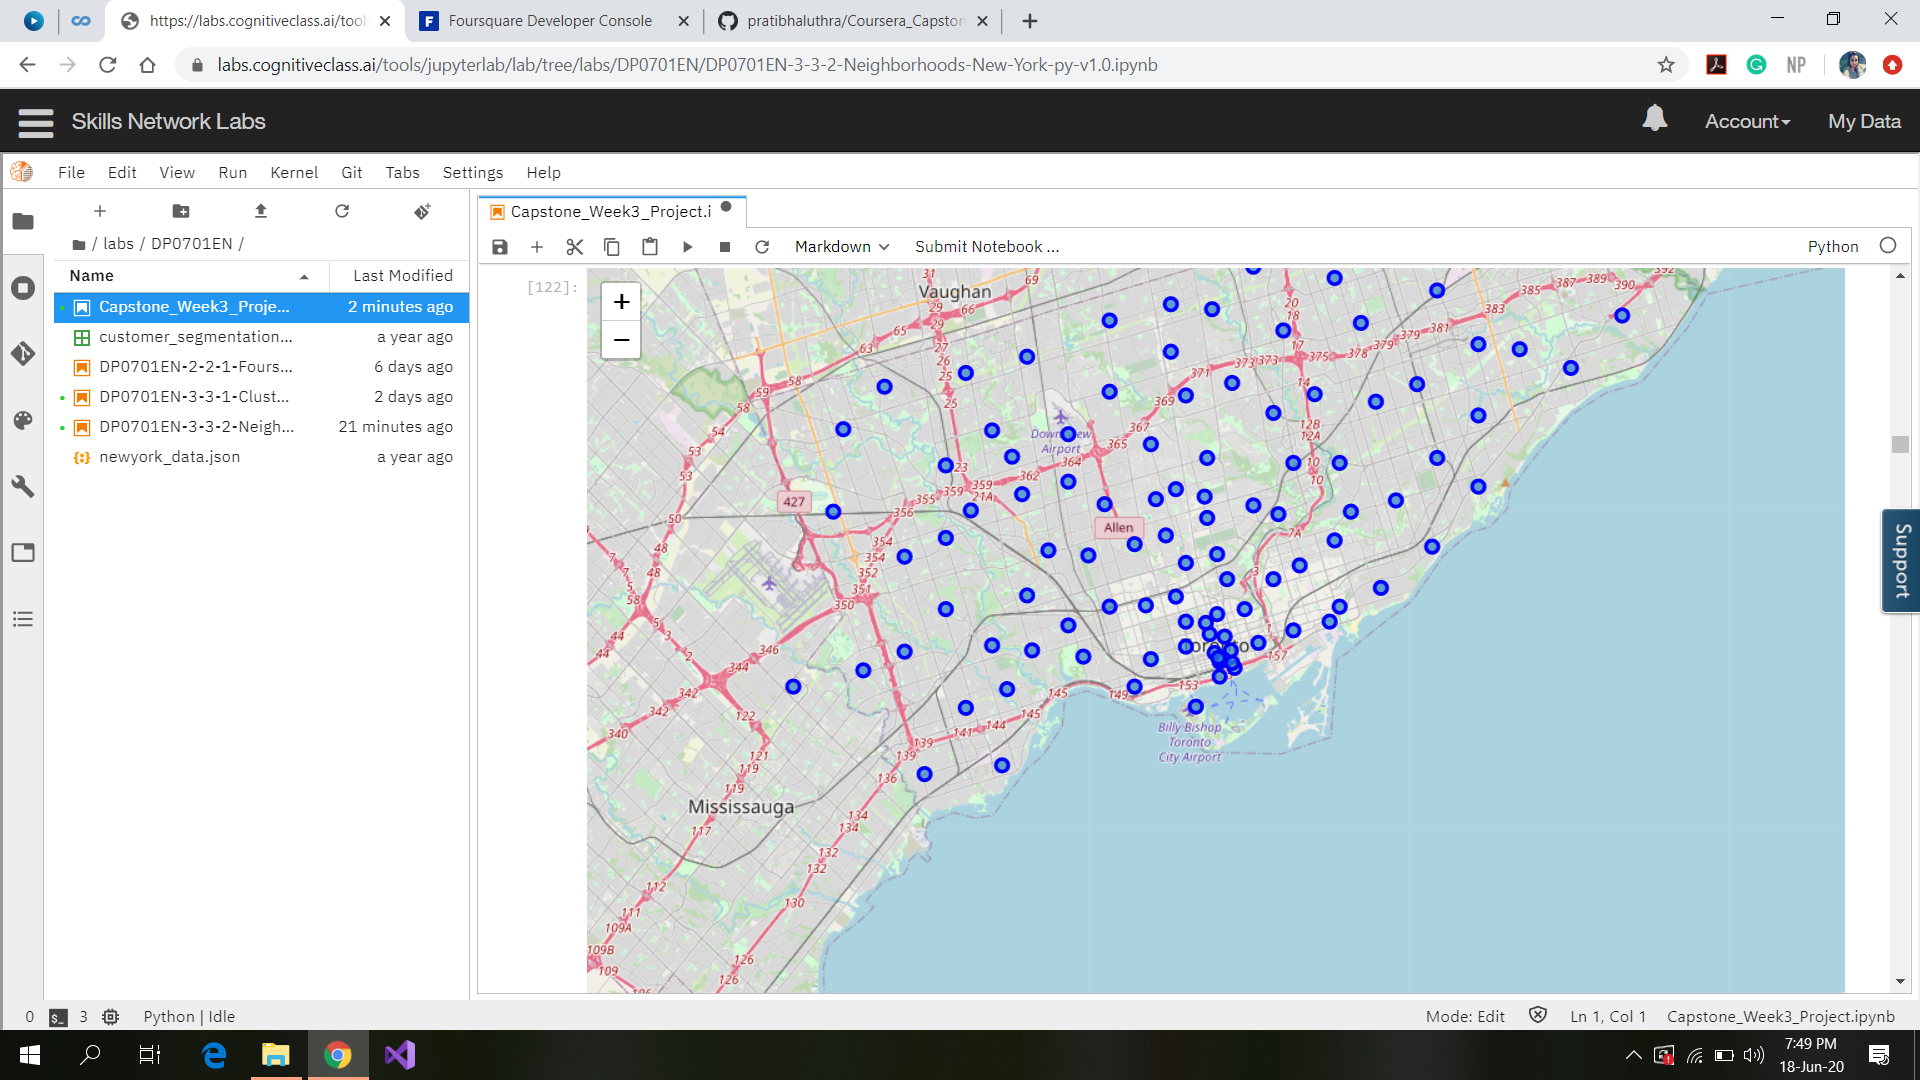

Defining Foursquare Credentials


In [30]:
CLIENT_ID = '' # Foursquare ID
CLIENT_SECRET = '' # Foursquare Secret
VERSION = '20200618' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1CV351J0MTT0CJ1USL4QPYJ1CR4D2D4LIICWJI3V5V02ZH3Y
CLIENT_SECRET:LWHBS4NKKNDE4D3C2MEB2TSIAHOQX2IP4QWJUBXW03EGEZUZ


Exploring Neighborhood of Toronto

In [31]:
LIMIT = 10
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
#to get new dataframe containing venues in neighborhood
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [34]:
print(toronto_venues.shape)
toronto_venues.head()

(688, 7)


Neighborhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2       Guildwood, Morningside, West Hill              43.763573   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                  Venue  Venue Latitude  \
0              -79.194353                Wendy’s       43.807448   
1              -79.160497  Royal Canadian Legion       43.782533   
2              -79.188711         RBC Royal Bank       43.766790   
3              -79.188711      G & G Electronics       43.765309   
4              -79.188711       Big Bite Burrito       43.766299   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.191151                  Bank  
3       -79.191537     Electronics Store  
4       -79.190720    Mexican Restaurant

In [35]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        10   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      10   
Berczy Park                                                            10   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           10   
Business reply mail Processing Centre, South Ce...                     10   
CN Tower, King and Spadina, Railway Lands, Harb...                     10   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  10   
Cedarbrae                                                               8   
Central Bay Street                                                     10   
Christie                                                               10   
Church and Wellesley                                                   10   
Clarks Corners, Tam O'Shanter, Sullivan                                10   
Cliffside, Cliffcrest, Scarborough Village West                         3   
Commerce Court, Victoria Hotel                                         10   
Davisville                                                             10   
Davisville North                                                        8   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills                                                              14   
Dorset Park, Wexford Heights, Scarborough Town ...                      7   
Downsview                                                              16   
Dufferin, Dovercourt Village                                           10   
East Toronto, Broadview North (Old East York)                           4   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      9   
Fairview, Henry Farm, Oriole                                           10   
First Canadian Place, Underground city                                 10   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                               10   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                      10   
High Park, The Junction South                                          10   
Hillcrest Village                                                       4   
Humber Summit                                                           2   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         10   
Kennedy Park, Ionview, East Birchmount Park                             7   
Kensington Market, Chinatown, Grange Park                              10   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       10   
Lawrence Park                                                           3   
Leaside                                                                10   
Little Portugal, Trinity                                               10   
Malvern, Rouge                                                          1   
Milliken, Agincourt North, Steeles East, L'Amor.

In [36]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 180 uniques categories.


##### Analyze each neighborhood

In [51]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[124]] + list(toronto_onehot.columns[:])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot = toronto_onehot.loc[:,~toronto_onehot.columns.duplicated()]

toronto_onehot.head()

Neighborhood  Accessories Store  Airport  \
0                          Malvern, Rouge                  0        0   
1  Rouge Hill, Port Union, Highland Creek                  0        0   
2       Guildwood, Morningside, West Hill                  0        0   
3       Guildwood, Morningside, West Hill                  0        0   
4       Guildwood, Morningside, West Hill                  0        0   

   Airport Food Court  Airport Lounge  Airport Terminal  American Restaurant  \
0                   0               0                 0                    0   
1                   0               0                 0                    0   
2                   0               0                 0                    0   
3                   0               0                 0                    0   
4                   0               0                 0                    0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0            0                    0                 0   
1             0            0                    0                 0   
2             0            0                    0                 0   
3             0            0                    0                 0   
4             0            0                    0                 0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Bakery  Bank  Bar  \
0                   0              0          0       0     0    0   
1                   0              0          0       0     0    1   
2                   0              0          0       0     1    0   
3                   0              0          0       0     0    0   
4                   0              0          0       0     0    0   

   Baseball Field  Basketball Court  Beer Bar  Beer Store  Bike Shop  \
0               0                 0         0           0          0   
1               0                 0         0           0          0   
2               0                 0         0           0          0   
3               0                 0         0           0          0   
4               0                 0         0           0          0   

   Bookstore  Boutique  Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  \
0          0         0               0        0            0                0   
1          0         0               0        0            0                0   
2          0         0               0        0            0                0   
3          0         0               0        0            0                0   
4          0         0               0        0            0                0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Bus Stop  Café  \
0             0              0         0            0         0     0   
1             0              0         0            0         0     0   
2             0              0         0            0         0     0   
3             0              0         0            0         0     0   
4             0              0         0            0         0     0   

   Candy Store  Caribbean Restaurant  Chinese Restaurant  Clothing Store  \
0            0                     0                   0               0   
1            0                     0                   0               0   
2            0                     0                   0               0   
3            0                     0                   0               0   
4            0                     0                   0               0   

   Cocktail Bar  Coffee Shop  College Stadium  Comfort Food Restaurant  \
0             0            0                0                        0   
1             0            0                0                        0   
2             0            0                0                        0   
3             0            0                0                        0   
4             0            0                0                        0   



In [52]:
toronto_onehot.shape

(688, 180)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [53]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Accessories Store  \
0                                           Agincourt                0.0   
1                              Alderwood, Long Branch                0.0   
2     Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                     Bayview Village                0.0   
4                   Bedford Park, Lawrence Manor East                0.0   
5                                         Berczy Park                0.0   
6                         Birch Cliff, Cliffside West                0.0   
7        Brockton, Parkdale Village, Exhibition Place                0.0   
8   Business reply mail Processing Centre, South C...                0.0   
9   CN Tower, King and Spadina, Railway Lands, Har...                0.0   
10                                Caledonia-Fairbanks                0.0   
11              Canada Post Gateway Processing Centre                0.0   
12                                          Cedarbrae                0.0   
13                                 Central Bay Street                0.0   
14                                           Christie                0.0   
15                               Church and Wellesley                0.0   
16            Clarks Corners, Tam O'Shanter, Sullivan                0.0   
17    Cliffside, Cliffcrest, Scarborough Village West                0.0   
18                     Commerce Court, Victoria Hotel                0.0   
19                                         Davisville                0.0   
20                                   Davisville North                0.0   
21   Del Ray, Mount Dennis, Keelsdale and Silverthorn                0.0   
22                                          Don Mills                0.0   
23  Dorset Park, Wexford Heights, Scarborough Town...                0.0   
24                                          Downsview                0.0   
25                       Dufferin, Dovercourt Village                0.0   
26      East Toronto, Broadview North (Old East York)                0.0   
27  Eringate, Bloordale Gardens, Old Burnhamthorpe...                0.0   
28                       Fairview, Henry Farm, Oriole                0.0   
29             First Canadian Place, Underground city                0.0   
30    Forest Hill North & West, Forest Hill Road Park                0.0   
31                           Garden District, Ryerson                0.0   
32                                          Glencairn                0.0   
33                    Golden Mile, Clairlea, Oakridge                0.0   
34                  Guildwood, Morningside, West Hill                0.0   
35  Harbourfront East, Union Station, Toronto Islands                0.0   
36                      High Park, The Junction South                0.0   
37                                  Hillcrest Village                0.0   
38                                      Humber Summit                0.0   
39                                   Humberlea, Emery                0.0   
40                                 Humewood-Cedarvale                0.0   
41                     India Bazaar, The Beaches West                0.0   
42        Kennedy Park, Ionview, East Birchmount Park                0.0   
43          Kensington Market, Chinatown, Grange Park                0.0   
44  Kingsview Village, St. Phillips, Martin Grove ...                0.0   
45                   Lawrence Manor, Lawrence Heights                0.1   
46                                      Lawrence Park                0.0   
47                                            Leaside                0.0   
48                           Little Portugal, Trinity                0.0   
49                                     Malvern, Rouge                0.0   
50  Milliken, Agincourt North, Steeles East, L'Amo...                0.0   
51  Mimico NW, The Queensway West, South of Bloor,...                0.0   
52           

In [54]:
toronto_grouped.shape

(94, 180)

#### Getting top 10 venues in each Neighborhoof and putting in Dataframe

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Agincourt        Breakfast Spot   
1                           Alderwood, Long Branch           Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
3                                  Bayview Village   Japanese Restaurant   
4                Bedford Park, Lawrence Manor East            Restaurant   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0                Lounge  Latin American Restaurant          Skating Rink   
1                   Gym                        Pub           Coffee Shop   
2           Bridal Shop                       Bank         Deli / Bodega   
3                  Bank         Chinese Restaurant                  Café   
4    Italian Restaurant    Comfort Food Restaurant           Coffee Shop   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                Yoga Studio                 Field  Fast Food Restaurant   
1         Athletics & Sports        Sandwich Place        Discount Store   
2  Middle Eastern Restaurant                 Diner        Ice Cream Shop   
3                Yoga Studio                 Field  Fast Food Restaurant   
4                        Pub             Juice Bar                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0        Farmers Market    Falafel Restaurant            Event Space  
1    Falafel Restaurant           Event Space      Electronics Store  
2            Restaurant   Fried Chicken Joint   Fast Food Restaurant  
3        Farmers Market    Falafel Restaurant            Event Space  
4     Indian Restaurant      Sushi Restaurant        Thai Restaurant

## Clustering Neighborhoods

### Answer 3

In [112]:
# set number of clusters
kclusters = 6

toronto_group_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 2, 2, 2, 2, 2, 2, 3, 1], dtype=int32)

In [113]:
neighborhoods_venues_sorted.drop(['Cluster Labels'],axis= 1,inplace=True)
neighborhoods_venues_sorted.head()


Neighborhood 1st Most Common Venue  \
0                                        Agincourt        Breakfast Spot   
1                           Alderwood, Long Branch           Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
3                                  Bayview Village   Japanese Restaurant   
4                Bedford Park, Lawrence Manor East            Restaurant   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0                Lounge  Latin American Restaurant          Skating Rink   
1                   Gym                        Pub           Coffee Shop   
2           Bridal Shop                       Bank         Deli / Bodega   
3                  Bank         Chinese Restaurant                  Café   
4    Italian Restaurant    Comfort Food Restaurant           Coffee Shop   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                Yoga Studio                 Field  Fast Food Restaurant   
1         Athletics & Sports        Sandwich Place        Discount Store   
2  Middle Eastern Restaurant                 Diner        Ice Cream Shop   
3                Yoga Studio                 Field  Fast Food Restaurant   
4                        Pub             Juice Bar                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0        Farmers Market    Falafel Restaurant            Event Space  
1    Falafel Restaurant           Event Space      Electronics Store  
2            Restaurant   Fried Chicken Joint   Fast Food Restaurant  
3        Farmers Market    Falafel Restaurant            Event Space  
4     Indian Restaurant      Sushi Restaurant        Thai Restaurant

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [114]:
#adding Cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')

toronto_merged.head() # check the last columns!

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353               3  Fast Food Restaurant           Yoga Studio   
1 -79.160497               4                   Bar           Yoga Studio   
2 -79.188711               3        Breakfast Spot        Medical Center   
3 -79.216917               1           Coffee Shop     Korean Restaurant   
4 -79.239476               2      Hakka Restaurant    Athletics & Sports   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Convenience Store                 Field        Farmers Market   
1               Dog Run                 Field  Fast Food Restaurant   
2    Mexican Restaurant   Rental Car Location     Electronics Store   
3           Yoga Studio               Dog Run                 Field   
4   Fried Chicken Joint                  Bank                Bakery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Falafel Restaurant           Event Space     Electronics Store   
1        Farmers Market    Falafel Restaurant           Event Space   
2         Moving Target                  Bank          Intersection   
3  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
4       Thai Restaurant           Gas Station  Caribbean Restaurant   

         9th Most Common Venue       10th Most Common Venue  
0  Eastern European Restaurant                    Drugstore  
1            Electronics Store  Eastern European Restaurant  
2                    Drugstore         Fast Food Restaurant  
3                  Event Space            Electronics Store  
4               Discount Store          Distribution Center

Visualizing Clusters

In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

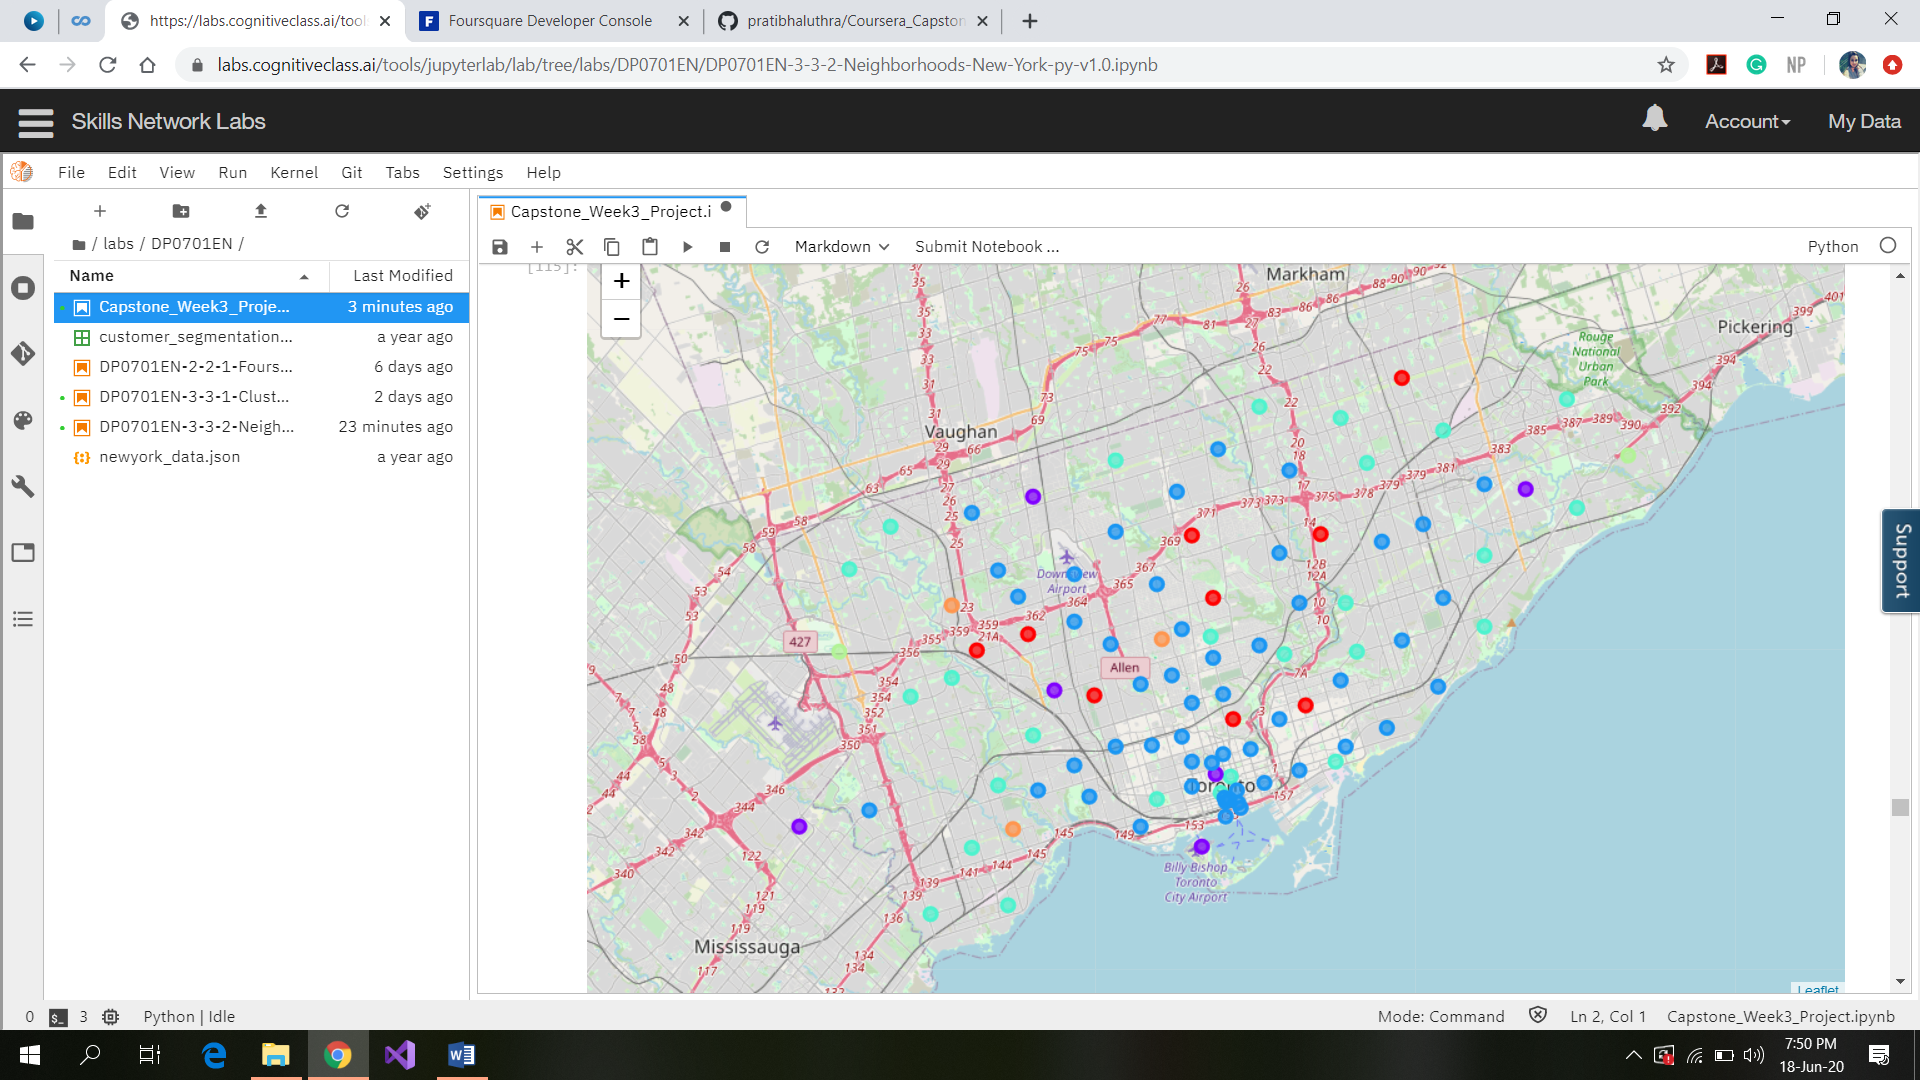

## Examine Clsuters

#### Cluster 1

In [116]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels       1st Most Common Venue  \
14       Scarborough               0                  Playground   
23        North York               0           Convenience Store   
25        North York               0  Construction & Landscaping   
40         East York               0                        Park   
44   Central Toronto               0                        Park   
50  Downtown Toronto               0                        Park   
74              York               0                        Park   
79        North York               0  Construction & Landscaping   
98              York               0           Convenience Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
14                  Park        Discount Store        Farmers Market   
23                  Park   Distribution Center  Fast Food Restaurant   
25     Food & Drink Shop                  Park   Distribution Center   
40     Convenience Store         Metro Station   Distribution Center   
44           Swim School              Bus Line           Yoga Studio   
50            Playground                 Trail        Discount Store   
74         Women's Store                  Pool           Yoga Studio   
79                  Park      Basketball Court                Bakery   
98                  Park   Distribution Center  Fast Food Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
14    Falafel Restaurant           Event Space     Electronics Store   
23        Farmers Market    Falafel Restaurant           Event Space   
25  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
40        Farmers Market    Falafel Restaurant           Event Space   
44   Distribution Center        Farmers Market    Falafel Restaurant   
50        Farmers Market    Falafel Restaurant           Event Space   
74        Discount Store        Farmers Market    Falafel Restaurant   
79           Yoga Studio             Drugstore                 Field   
98        Farmers Market    Falafel Restaurant           Event Space   

          8th Most Common Venue        9th Most Common Venue  \
14  Eastern European Restaurant                    Drugstore   
23            Electronics Store  Eastern European Restaurant   
25                  Event Space            Electronics Store   
40            Electronics Store  Eastern European Restaurant   
44                  Event Space            Electronics Store   
50            Electronics Store  Eastern European Restaurant   
74                  Event Space            Electronics Store   
79         Fast Food Restaurant               Farmers Market   
98            Electronics Store  Eastern European Restaurant   

         10th Most Common Venue  
14                      Dog Run  
23                    Drugstore  
25  Eastern European Restaurant  
40                    Drugstore  
44  Eastern European Restaurant  
50                    Drugstore  
74  Eastern European Restaurant  
79           Falafel Restaurant  
98                    Drugstore

#### Cluster 2

In [117]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
3        Scarborough               1           Coffee Shop   
29        North York               1  Caribbean Restaurant   
57  Downtown Toronto               1           Coffee Shop   
68  Downtown Toronto               1        Airport Lounge   
80              York               1        Sandwich Place   
86       Mississauga               1           Coffee Shop   

         2nd Most Common Venue     3rd Most Common Venue  \
3            Korean Restaurant               Yoga Studio   
29               Metro Station        Falafel Restaurant   
57  Modern European Restaurant           Bubble Tea Shop   
68             Harbor / Marina                     Plane   
80                         Bar        Turkish Restaurant   
86                       Hotel  Mediterranean Restaurant   

        4th Most Common Venue      5th Most Common Venue  \
3                     Dog Run                      Field   
29         Miscellaneous Shop                Coffee Shop   
57  Middle Eastern Restaurant        Japanese Restaurant   
68                Coffee Shop                   Boutique   
80             Discount Store                Yoga Studio   
86              Burrito Place  Middle Eastern Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3   Fast Food Restaurant        Farmers Market    Falafel Restaurant   
29                   Bar        Massage Studio             Drugstore   
57    Italian Restaurant                   Spa           Yoga Studio   
68                   Bar      Airport Terminal    Airport Food Court   
80  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
86   American Restaurant   Fried Chicken Joint        Sandwich Place   

   9th Most Common Venue 10th Most Common Venue  
3            Event Space      Electronics Store  
29  Fast Food Restaurant         Farmers Market  
57        Farmers Market     Falafel Restaurant  
68               Airport                  Field  
80           Event Space      Electronics Store  
86             Drugstore         Farmers Market

#### Cluster 3

In [118]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels  1st Most Common Venue  \
4        Scarborough               2       Hakka Restaurant   
6        Scarborough               2      Convenience Store   
7        Scarborough               2               Bus Line   
9        Scarborough               2                   Café   
10       Scarborough               2      Indian Restaurant   
11       Scarborough               2             Smoke Shop   
18        North York               2             Restaurant   
19        North York               2    Japanese Restaurant   
22        North York               2                   Café   
26        North York               2    Japanese Restaurant   
27        North York               2    Japanese Restaurant   
28        North York               2            Coffee Shop   
30        North York               2          Grocery Store   
31        North York               2          Grocery Store   
32        North York               2          Grocery Store   
33        North York               2          Grocery Store   
36         East York               2               Pharmacy   
37      East Toronto               2      Health Food Store   
38         East York               2                    Gym   
41      East Toronto               2       Greek Restaurant   
42      East Toronto               2           Liquor Store   
43      East Toronto               2            Fish Market   
46   Central Toronto               2            Yoga Studio   
47   Central Toronto               2           Dessert Shop   
48   Central Toronto               2                   Park   
49   Central Toronto               2            Coffee Shop   
51  Downtown Toronto               2                   Café   
52  Downtown Toronto               2                   Park   
53  Downtown Toronto               2         Breakfast Spot   
55  Downtown Toronto               2            Coffee Shop   
56  Downtown Toronto               2      French Restaurant   
59  Downtown Toronto               2  Performing Arts Venue   
60  Downtown Toronto               2                    Gym   
61  Downtown Toronto               2                   Café   
62        North York               2             Restaurant   
64   Central Toronto               2                   Park   
65   Central Toronto               2                   Café   
66  Downtown Toronto               2            Yoga Studio   
67  Downtown Toronto               2                   Café   
69  Downtown Toronto               2           Concert Hall   
70  Downtown Toronto               2             Restaurant   
71        North York               2         Clothing Store   
72        North York               2                   Park   
73              York               2                  Field   
75  Downtown Toronto               2                   Café   
76      West Toronto               2                 Bakery   
78      West Toronto               2            Coffee Shop   
82      West Toronto               2            Flea Market   
83      West Toronto               2              Gift Shop   
84      West Toronto               2       Sushi Restaurant   
85  Downtown Toronto               2       Sushi Restaurant   
95         Etobicoke               2      Convenience Store   

        2nd Most Common Venue          3rd Most Common Venue  \
4          Athletics & Sports            Fried Chicken Joint   
6            Department Store                    Bus Station   
7                      Bakery                   Intersection   
9             College Stadium                   Skating Rink   
10         Chinese Restaurant          Vietnamese Restaurant   
11  Middle Eastern Restaurant                         Bakery   
18                     Bakery              Electronics Store   
19                       Bank             Chinese Restaurant   
22      Indonesian Restaurant                  Grocery Store   
26                        Gym    

#### Cluster 4

In [119]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels       1st Most Common Venue  \
0         Scarborough               3        Fast Food Restaurant   
2         Scarborough               3              Breakfast Spot   
5         Scarborough               3                  Playground   
8         Scarborough               3                       Motel   
12        Scarborough               3              Breakfast Spot   
13        Scarborough               3                 Pizza Place   
15        Scarborough               3          Chinese Restaurant   
17         North York               3    Mediterranean Restaurant   
24         North York               3                 Pizza Place   
34         North York               3                Intersection   
35          East York               3                 Pizza Place   
39          East York               3           Indian Restaurant   
45    Central Toronto               3              Breakfast Spot   
54   Downtown Toronto               3                  Comic Shop   
58   Downtown Toronto               3        Gym / Fitness Center   
77       West Toronto               3                 Pizza Place   
81               York               3           Convenience Store   
87       East Toronto               3                  Restaurant   
88          Etobicoke               3                Liquor Store   
89          Etobicoke               3                 Pizza Place   
90          Etobicoke               3                        Pool   
92          Etobicoke               3              Hardware Store   
96         North York               3  Construction & Landscaping   
99          Etobicoke               3                 Pizza Place   
100         Etobicoke               3              Sandwich Place   
101         Etobicoke               3               Grocery Store   

       2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0                Yoga Studio          Convenience Store                 Field   
2             Medical Center         Mexican Restaurant   Rental Car Location   
5          Fish & Chips Shop       Fast Food Restaurant        Farmers Market   
8        American Restaurant                Yoga Studio               Dog Run   
12                    Lounge  Latin American Restaurant          Skating Rink   
13               Gas Station        Fried Chicken Joint                  Bank   
15            Breakfast Spot                       Bank           Pizza Place   
17                      Pool                Golf Course               Dog Run   
24                  Pharmacy              Grocery Store           Coffee Shop   
34               Pizza Place      Portuguese Restaurant          Hockey Arena   
35      Gym / Fitness Center                  Gastropub                  Café   
39               Yoga Studio               Burger Joint         Grocery Store   
45      Gym / Fitness Center                Pizza Place                  Park   
54               Music Venue              Burrito Place                  Café   
58                     Hotel                Pizza Place                 Plaza   
77   New American Restaurant          Korean Restaurant        Ice Cream Shop   
81             Grocery Store             Breakfast Spot           Pizza Place   
87             Garden Center             Farmers Market         Burrito Place   
88                    Bakery                Pizza Place            Restaurant   
89                       Gym                        Pub           Coffee Shop   
90                     River                Yoga Studio        Discount Store   
92                    Bakery                Wings Joint     Convenience Store   
96               Pizza Place        Distribution Center  Fast Food Restaurant   
99               Coffee Shop  Middle Eastern Restaurant        Sandwich Place   
100                 Bus Line          Mobile Phone Shop           Pizza Place   
101                 Pharmacy        Fried Ch

#### CLuster 5

In [120]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
1    Scarborough               4                   Bar           Yoga Studio   
102    Etobicoke               4   Rental Car Location                   Bar   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1                 Dog Run                 Field  Fast Food Restaurant   
102             Drugstore           Yoga Studio   Distribution Center   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1          Farmers Market    Falafel Restaurant           Event Space   
102  Fast Food Restaurant        Farmers Market    Falafel Restaurant   

    9th Most Common Venue       10th Most Common Venue  
1       Electronics Store  Eastern European Restaurant  
102           Event Space            Electronics Store

#### Cluster 6

In [121]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
63  Central Toronto               5          Home Service   
91        Etobicoke               5          Home Service   
97       North York               5        Baseball Field   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
63                Garden           Yoga Studio   Distribution Center   
91        Baseball Field           Yoga Studio               Dog Run   
97           Yoga Studio               Dog Run                 Field   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
63  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
91                 Field  Fast Food Restaurant        Farmers Market   
97  Fast Food Restaurant        Farmers Market    Falafel Restaurant   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
63           Event Space     Electronics Store  Eastern European Restaurant  
91    Falafel Restaurant           Event Space            Electronics Store  
97           Event Space     Electronics Store  Eastern European Restaurant